Motivation:

Flakes of atomically thin layers of so-called van der Waals materials (such as graphene or its semiconducting analogue MoS2, which is considered here) being exfoliated onto Si/SiO2 substrates have a particular optical contrast depending on their thickness. Such contrast is determined by the phase shift of the interference color between a flake and Si/SiO2 substrate and is calculated as C=(I_background-I_flake)/I_background, where I_flake is intenstiy of a flake and I_background - intensity of Si/SiO2 substrate. 

Here I am aiming to built an algorithm that will enable to output whether a monolayer flake (an ultimate thickness that can be obtained; about 0.7 nm) of MoS2 is present in the image or not. 

That can be potentially useful to implement in the automated systems of flake search, in which an optical microscope scans large substrate areas and records coordinates of identified monolayers.

Using an approach based on machine-learning (in this case pre-trained VGG16 convolutional neural network) can be beneficial as compared to a 'rigidly' programmed algorithm (in which a monolayer is defined according to some fixed rules, let say having RGB values in a certain range) because the performance of such 'classical' algorithm in this case can be considerably decreased upon using images collected with different microscope illumination conditions and flakes deposited on different substrates (interference pattern also depend on the thickness of the underlying substrate), which is usually the case. Using CNN, however, I expect to overcome such limitation.

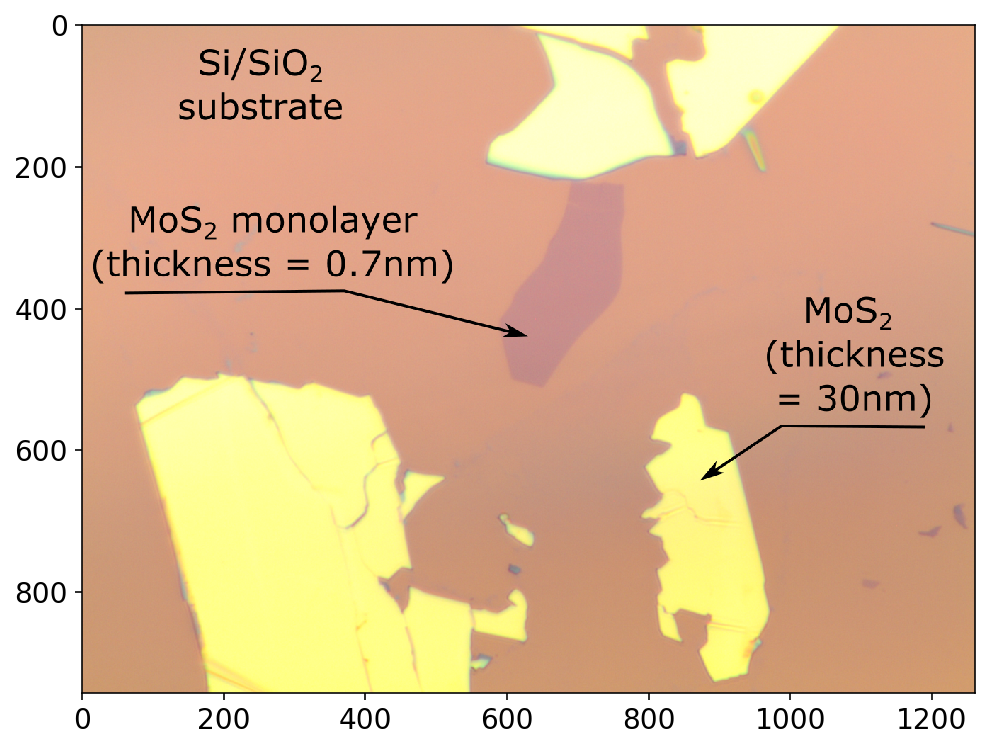

In [1]:
%config InlineBackend.figure_format='retina'
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import cv2

from PIL import Image
import os

plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 14
im = Image.open('C:/Users/Evgeniy/Desktop/Advanced computing/flake_example.png')
plt.imshow(im)

To be able to use VGG16 it is first required to label existing in-house collected images of flakes and adjust them to the appropriate format (224x224). 

Labeling is done using optical contrast method

Below there is an example for one image which is then used to treat all others

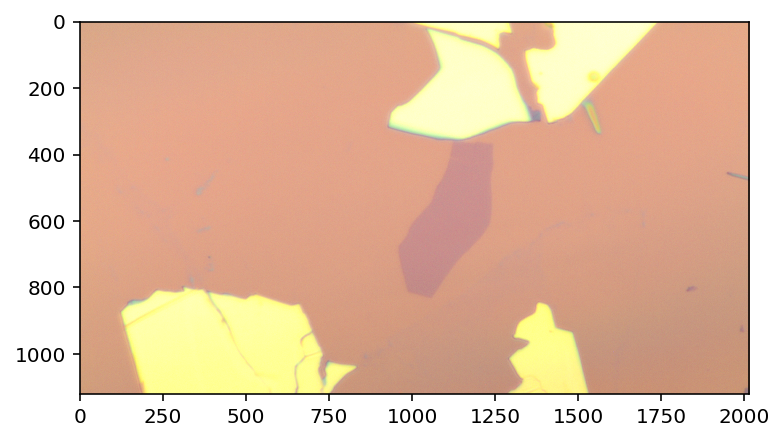

In [2]:
im = Image.open('C:/Users/Evgeniy/Desktop/Advanced computing/flakes/6.tif')
crbox=(0,0,9*224,5*224,)
im_cr=im.crop(crbox)
im_cr.save('C:/Users/Evgeniy/Desktop/Advanced computing/flakes/cr6.jpg') 
plt.imshow(im_cr)

The largest contrast between a MoS2 monolayer and a substrate is seen in the green image channel as shown below:

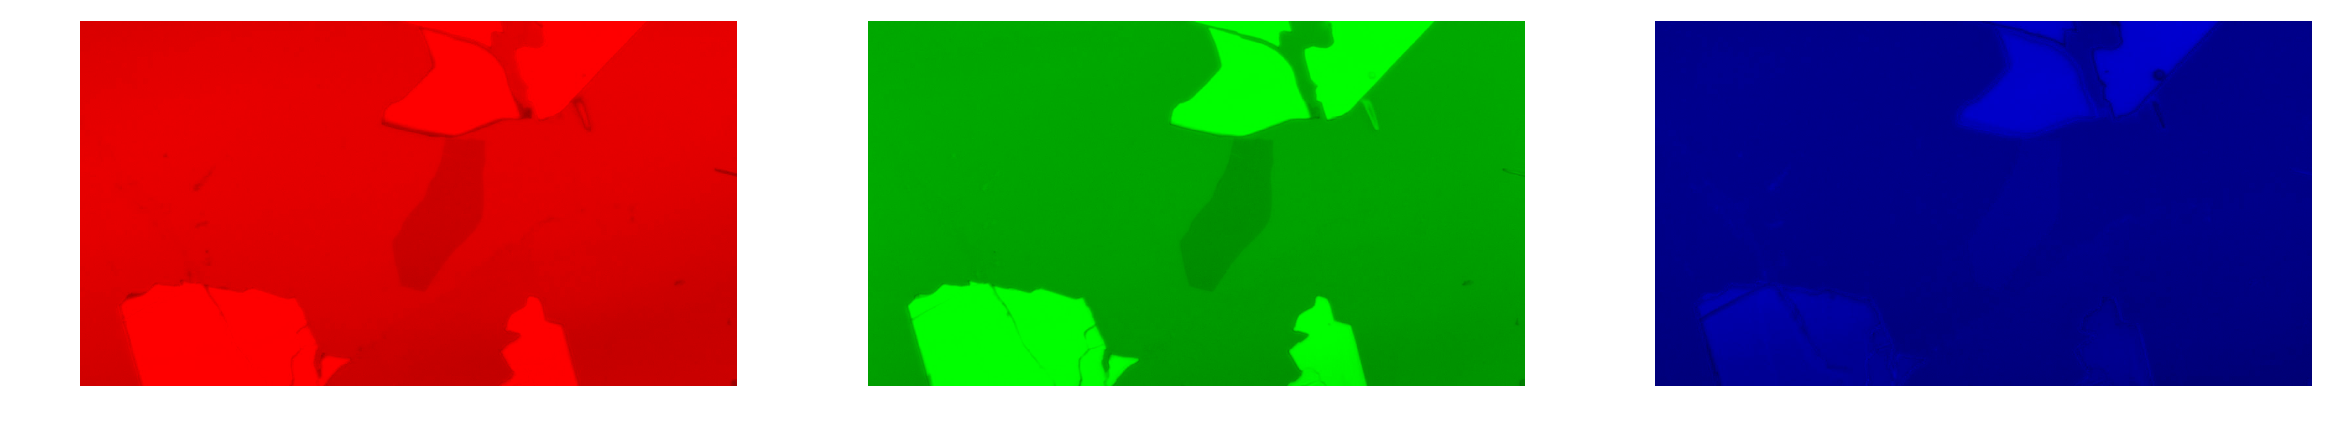

In [3]:
plt.rcParams["figure.figsize"] = (20, 20)
flake = plt.imread('C:/Users/Evgeniy/Desktop/Advanced computing/flakes/cr6.jpg')
figure, plots = plt.subplots(ncols=3, nrows=1)
for i, subplot in zip(range(3), plots):
    temp = np.zeros(flake.shape, dtype='uint8')
    temp[:,:,i] = flake[:,:,i]
    subplot.imshow(temp)
    subplot.set_axis_off()
plt.show()

As it is required for VGG 16, a typical image collected with a microscope is split into segments of 224x224 size:

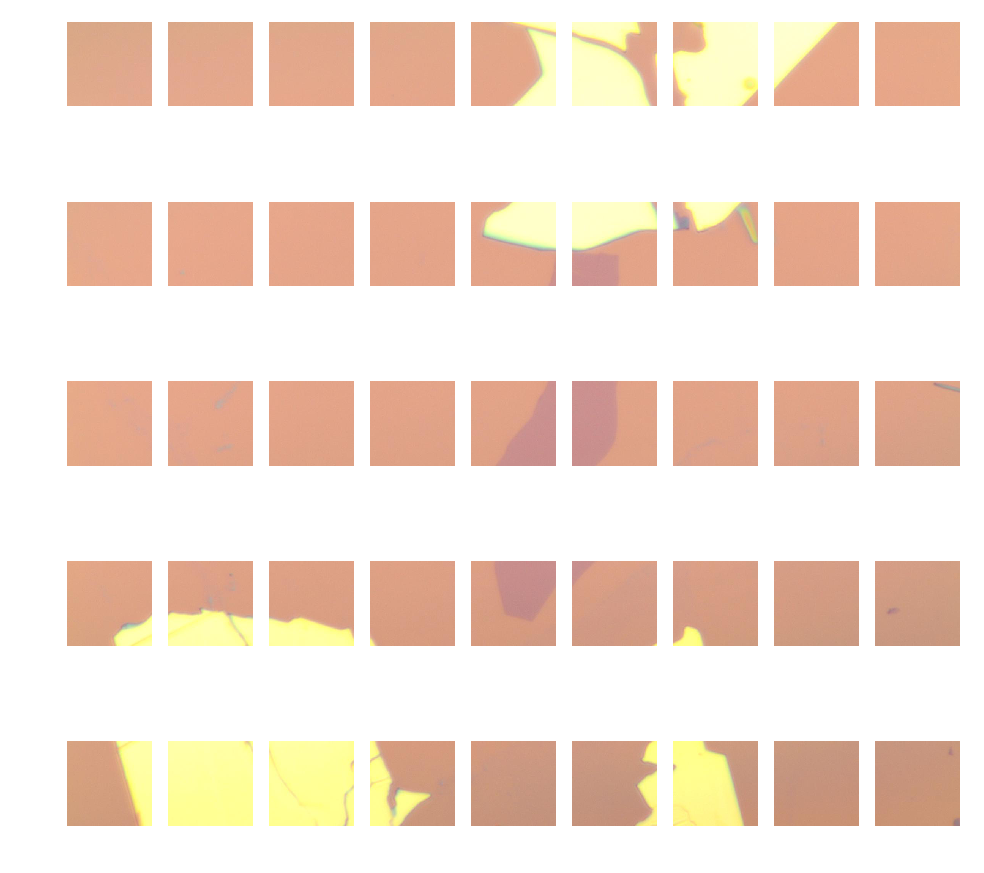

In [4]:
from PIL import Image
im = Image.open('C:/Users/Evgeniy/Desktop/Advanced computing/flakes/cr6.jpg')

plt.rcParams["figure.figsize"] = (8, 8)
l=0
for i in range(1,6,1):
    for j in range(1,10,1):
        box = ((j-1)*224, (i-1)*224, j*224, i*224)
        cropped_img = im.crop(box)
        l=l+1
        plt.subplot(5, 9, l)
        plt.imshow(cropped_img)
        cropped_img.save('C:/Users/Evgeniy/Desktop/Advanced computing/flakes/crfl6/cr'+str(l)+'.jpg') 
        plt.axis('off') 

plt.show()

To calculate an optical contrast with respect to the substrate we use and part of an image free of flakes. In this case:

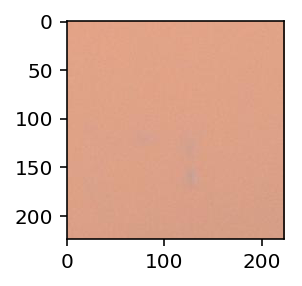

In [5]:
plt.rcParams["figure.figsize"] = (2, 2)
background = plt.imread('C:/Users/Evgeniy/Desktop/Advanced computing/flakes/crfl6/cr26.jpg')
plt.imshow(background)

Optical contrast calclulated for the green channel according to C=(I_bacground-I_image)/I_bacground:

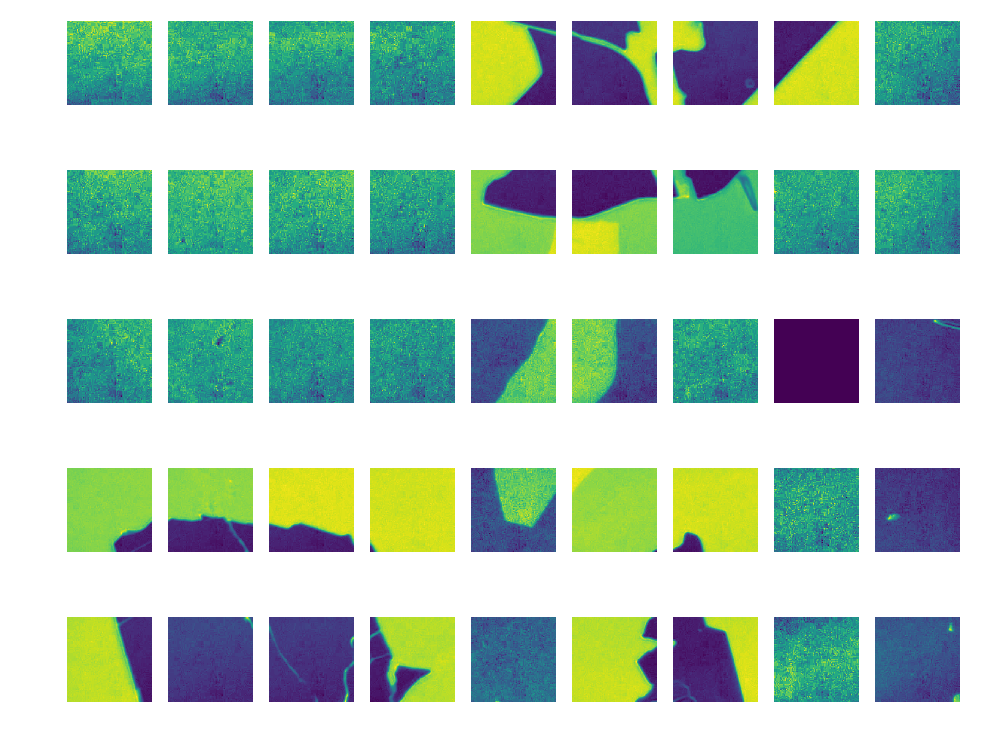

In [6]:
plt.rcParams["figure.figsize"] = (8, 8)

import cv2

l=0
for i in range(1,6,1):
    for j in range(1,10,1):
        l=l+1
        
        flake = plt.imread('C:/Users/Evgeniy/Desktop/Advanced computing/flakes/crfl6/cr'+str(l)+'.jpg')
        background = plt.imread('C:/Users/Evgeniy/Desktop/Advanced computing/flakes/crfl6/cr26.jpg')
       
        gr_chf=np.int16(flake[:,:,1]) 
        gr_chb=np.int16(background[:,:,1]) 
        
        plt.subplot(6, 9, l)
        
        fl_contrast=(gr_chb-gr_chf)/gr_chb
        plt.imshow(fl_contrast)
        plt.axis('off') 
    
        
       
                
plt.show()

According to the data shown in the literature (e.g. http://iopscience.iop.org/article/10.1088/0957-4484/22/12/125706/meta), the optical contrast of the monolayer should be in 0.12..0.2 range. Taking a histograms of the treated image and putting a threshold of counts in the appropriate range allow us to label images which contain monolayers. 

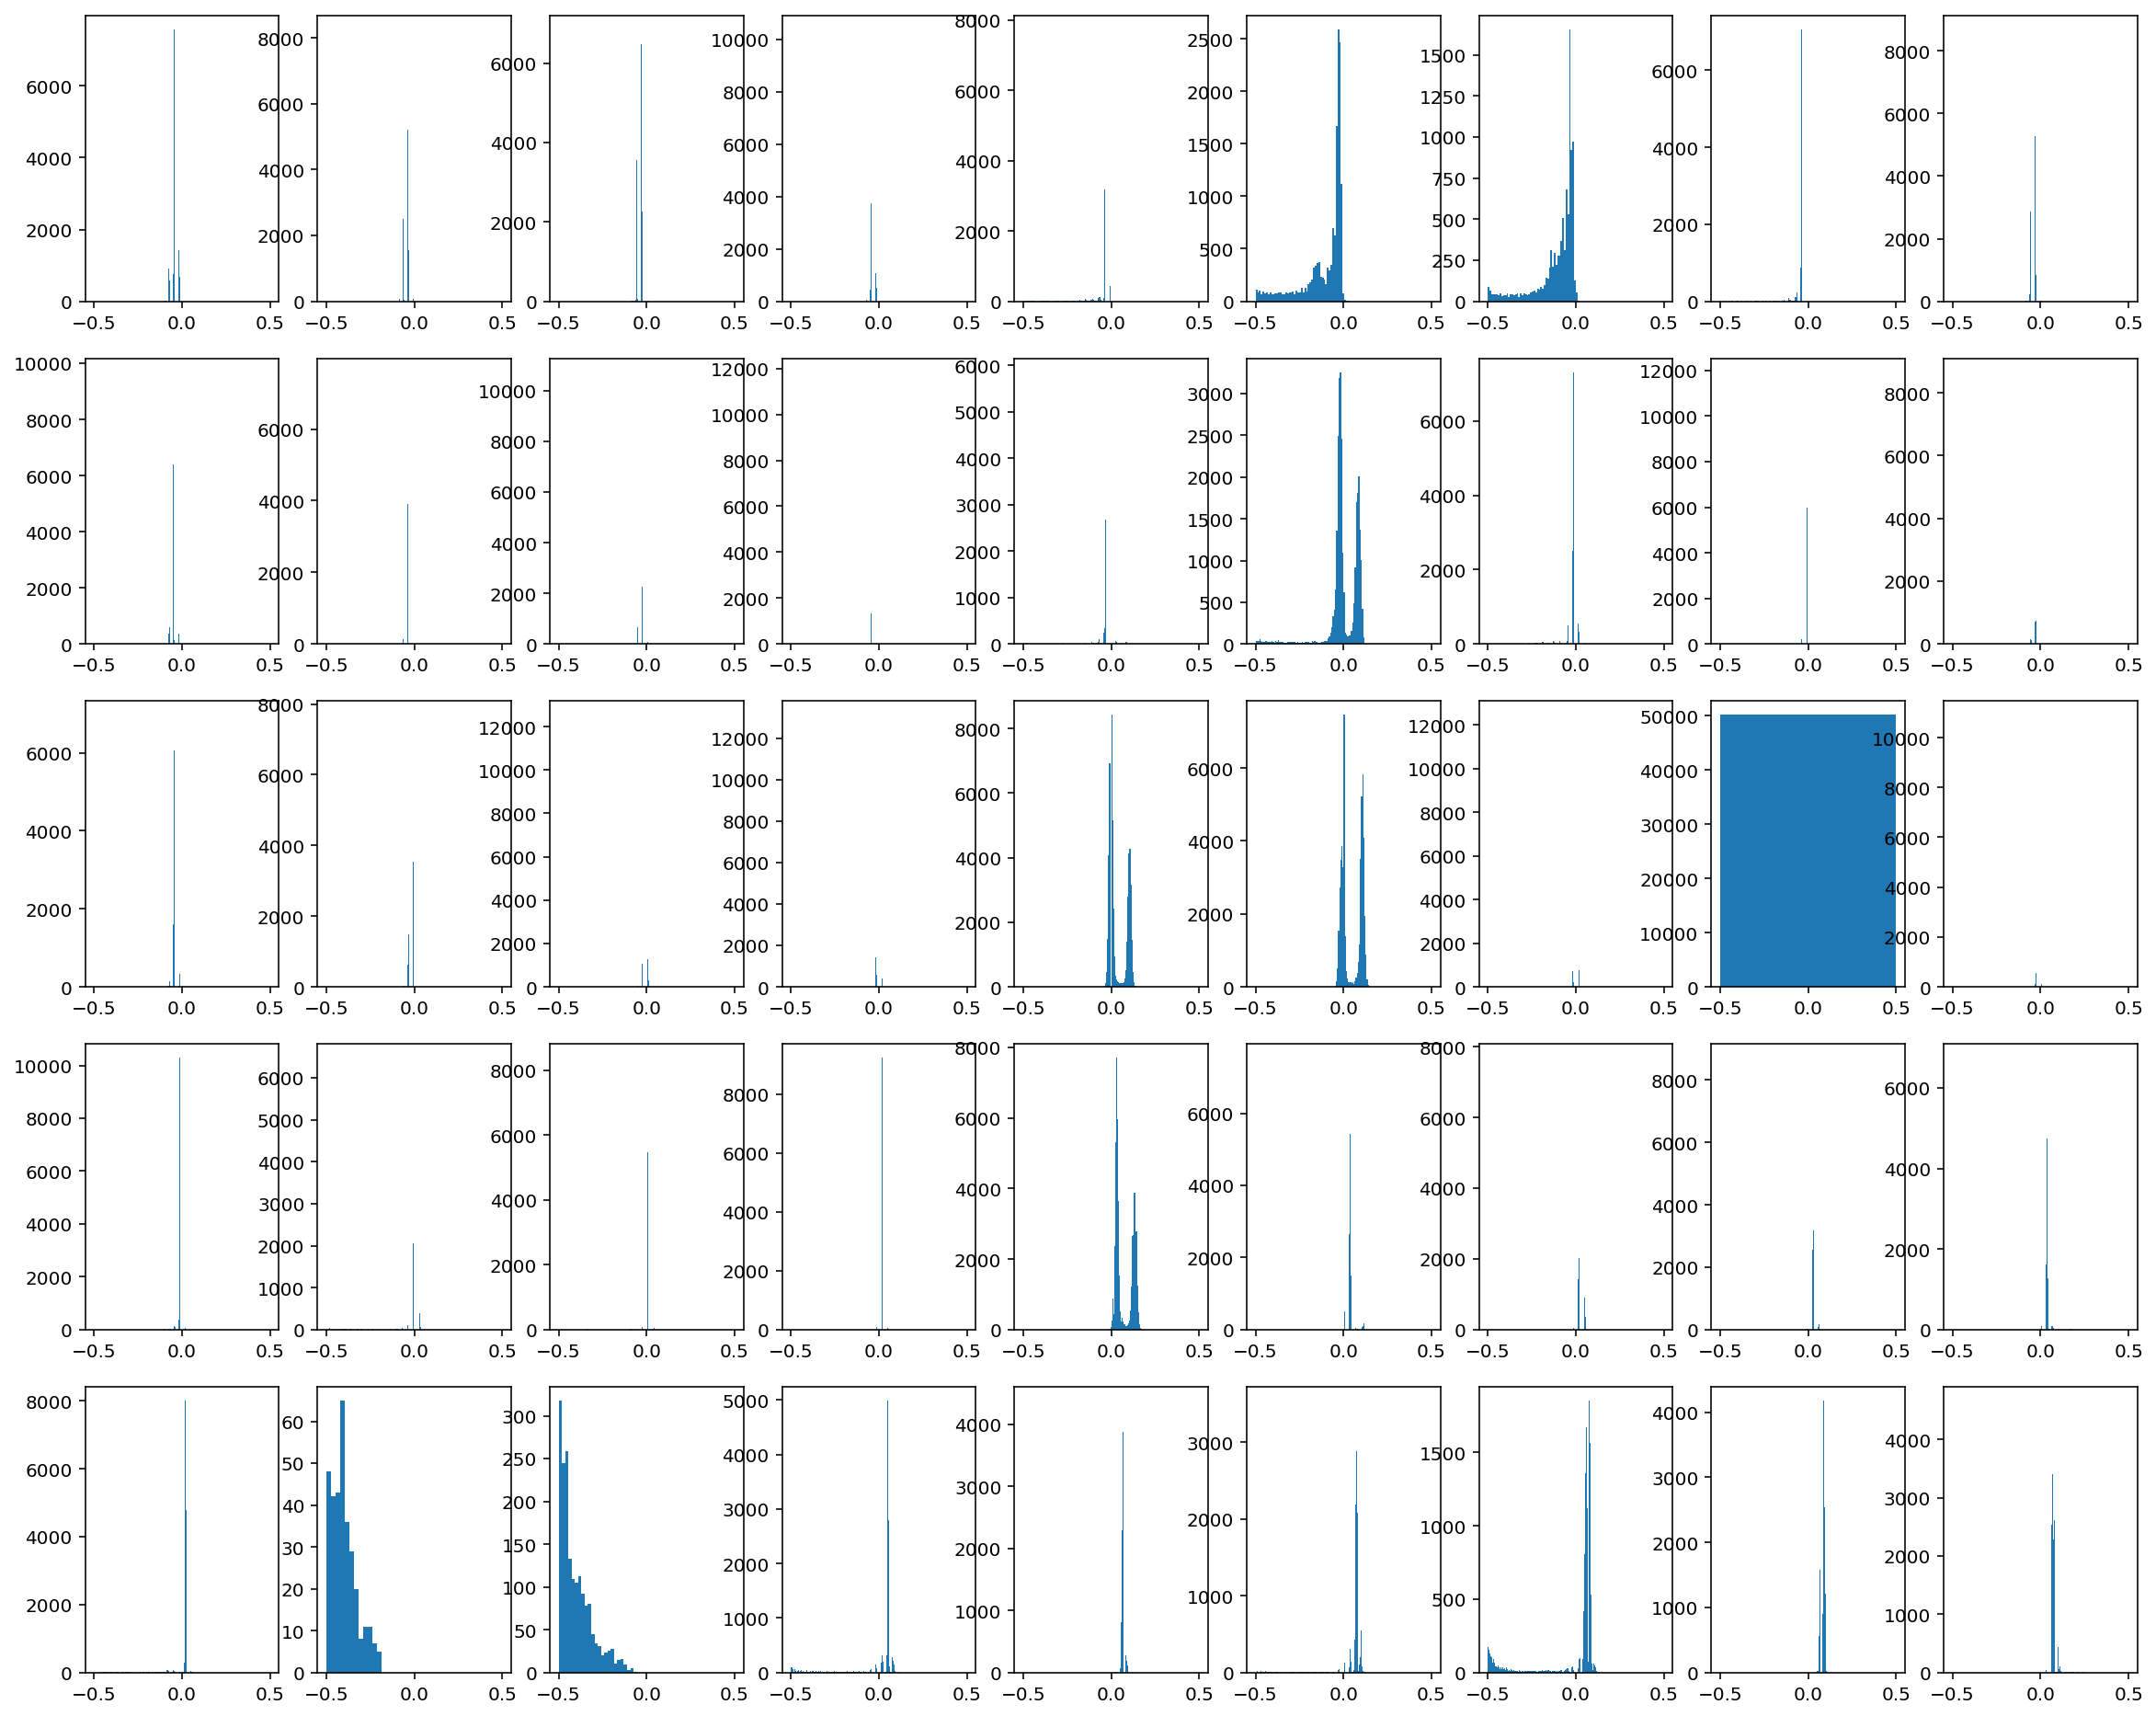

In [7]:
plt.rcParams["figure.figsize"] = (20, 20)

import cv2


l=0
for i in range(1,6,1):
    for j in range(1,10,1):
        l=l+1
        
        flake = plt.imread('C:/Users/Evgeniy/Desktop/Advanced computing/flakes/crfl6/cr'+str(l)+'.jpg')
        background = plt.imread('C:/Users/Evgeniy/Desktop/Advanced computing/flakes/crfl6/cr26.jpg')
       
        gr_chf=np.int16(flake[:,:,1]) 
        gr_chb=np.int16(background[:,:,1]) 
        plt.subplot(6, 9, l)
        fl_contrast=(gr_chb-gr_chf)/gr_chb
        a=fl_contrast.flatten()
        plt.hist(a, bins='auto', range=[-0.5,0.5])  
      
      
       
                
plt.show()

Marking images with monolayers:

In [18]:
l=0
m=0
ct_green=[]
#ct_red=[]
background = plt.imread('C:/Users/Evgeniy/Desktop/Advanced computing/flakes/crfl6/cr26.jpg')

for l in range(1,46,1):
    counter_green=0
    #counter_blue=0
    #counter_red=0
    flake = plt.imread('C:/Users/Evgeniy/Desktop/Advanced computing/flakes/crfl6/cr'+str(l)+'.jpg')
    
    
   # r_chf=np.int16(flake[:,:,0]) 
   # r_chb=np.int16(background[:,:,0])
   # fl_contrast_r=(r_chb-r_chf)/r_chb

    gr_chf=np.int16(flake[:,:,1]) 
    gr_chb=np.int16(background[:,:,1])
    fl_contrast_g=(gr_chb-gr_chf)/gr_chb                        
    
    
    for i in range(gr_chf.shape[0]):
        for j in range(gr_chf.shape[1]):
            if 0.09 < fl_contrast_g[i, j] <0.2:
                counter_green += 1
            #if 0< fl_contrast_r[i, j] <0.2:
               # counter_red += 1    

            
            
            
    #ct_red.append(counter_red)
    ct_green.append(counter_green);
    
    
        
labels=[0]*len(ct_green)

for m in range(0,45,1):
    
      if  ct_green[m]>12000:
                   
            labels[m] = 1;

In [19]:
l=0;

A=np.zeros((5, 9))
for i in range(0,5,1):
    for j in range(0,9,1):
       
        A[i][j]=labels[l]
        l+=1;

print(A)

[[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [21]:
l=0
ct_green=[]


for l in range(1,3025,1):
    
    
    counter_green=0
    flake = plt.imread('C:/Users/Evgeniy/Desktop/Advanced computing/flakes/treated/tr'+str(l)+'.jpg')
    
    background = np.zeros((224,224,3), dtype='uint8') # since considred images were taken under different illumination condictions
                                                    # I simulate the background by taking the first column of the image and propogate it to make 224x224 image 

    for d in range(0,224,1):
        background[:223,d,:]=flake[:223,0,:]


 

    gr_chf=np.int16(flake[:,:,1]) 
    gr_chb=np.int16(background[:,:,1])
    fl_contrast_g=(gr_chb-gr_chf)/gr_chb                        
    
    
    for i in range(gr_chf.shape[0]):
        for j in range(gr_chf.shape[1]):
            if 0.09 < fl_contrast_g[i, j] <0.2:
                counter_green += 1
            #if 0< fl_contrast_r[i, j] <0.2:
               # counter_red += 1    

            
            
            
    #ct_red.append(counter_red)
    ct_green.append(counter_green);     
            
  

C:\Users\Evgeniy\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide


Names of images containing monolayers are output into .txt file

In [43]:
import numpy as np
m=0
labels=[]
for m in range(0,3024,1):
    
      if ct_green[m]>12000:
            labels.append(m);

np.savetxt('C:/Users/Evgeniy/Desktop/Advanced computing/flakes/monolayer_labels.txt', labels, delimiter=',', fmt='%d')